In [1]:
#import required packages

from tqdm import tqdm_notebook as tqdm
import os
import csv
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from math import *

In [2]:
#loading the data in dataframe df

#data - https://ourworldindata.org/coronavirus
df = pd.read_csv('/Users/digisha/Downloads/owid-covid-data.csv')
df.head(5)

,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units
0,ABW,Aruba,2020-03-13,2,2,0,0,18.733,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,ABW,Aruba,2020-03-20,4,2,0,0,37.465,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,ABW,Aruba,2020-03-24,12,8,0,0,112.395,74.930,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,ABW,Aruba,2020-03-25,17,5,0,0,159.227,46.831,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,ABW,Aruba,2020-03-26,19,2,0,0,177.959,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [3]:
#selected list of countries
#countries = ["Albania", "Austria",'Belgium','France','Greece','Iceland','Italy', "Spain",'Sweden','Turkey','United Kingdom']

In [4]:
#Filtering dataset to limit the data limited to specific coutries in ndf dataframe
#ndf = df[df['location'].isin(countries)].reset_index()
ndf = df
ndf.head()

,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units
0,ABW,Aruba,2020-03-13,2,2,0,0,18.733,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,ABW,Aruba,2020-03-20,4,2,0,0,37.465,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,ABW,Aruba,2020-03-24,12,8,0,0,112.395,74.930,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,ABW,Aruba,2020-03-25,17,5,0,0,159.227,46.831,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,ABW,Aruba,2020-03-26,19,2,0,0,177.959,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [5]:
#Functions to calculate total cases and deaths per 100k
func1 = (lambda x: x.max()/10)

#Functions to calculate total tests per 100k
func2 = (lambda x: x.max()*100)

#grouping the data by the countries to get its statitics
summary = ndf.groupby(['location'],as_index=False).agg(
    {'total_cases': {'cases':np.max},
     'total_deaths': {'deaths':np.max},
     'total_tests': {'tests':np.max},
     'total_cases_per_million': {'cases/100k': func1},
     'total_deaths_per_million': {'deaths/100k':func1},
     "total_tests_per_thousand":{"test/100k":func2}
    })

summary.columns = summary.columns.droplevel()
summary.rename(columns={'':'location'}, inplace=True)
cols = ['tests',"cases/100k", "deaths/100k","test/100k"]
summary[cols] = summary[cols].apply(np.rint) #to convert the data to integers
summary.reset_index(drop=True)
summary.head()

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/groupby/generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,location,cases,deaths,tests,cases/100k,deaths/100k,test/100k
0,Afghanistan,3392,104,NaN,9.0,0.0,NaN
1,Albania,832,31,NaN,29.0,1.0,NaN
2,Algeria,4997,476,NaN,11.0,1.0,NaN
3,Andorra,751,46,NaN,972.0,60.0,NaN
4,Angola,36,2,NaN,0.0,0.0,NaN


In [6]:
#list of number of days after the 100th case, in the order of the locations in the list countries
list = []
countries = ndf.location.unique()
with tqdm(total= (len(countries))) as pbar:

    for location in countries:
        #temp data frame with data only of the location country
        temp_df = df[df['location']==location]

        #Number of days after the 100th case = index maximum total case - index of the first row with equal or a little above 100 total cases
        #(max - considering it has latest stats, and we have data for every day, as finding latest date and its calculation is time consuming)
        case = (temp_df['total_cases'].idxmax())-((temp_df['total_cases'] - 100).apply(abs).idxmin())

        #appending the number of days after the 100th case of the location
        list.append(case)
        
        pbar.update(1)

#temprory dataframe with location and thier number of days after 100th case table
temp_df = pd.DataFrame({'location': countries, '100th_case': list})

#using couuntries with atleast 1.5 month of data after the 100th case
temp_df = temp_df[temp_df['100th_case']>45].reset_index(drop=True)

#combining the summary and temprory dataframe to get the desired results in the result table.
result = pd.merge(summary, temp_df, on='location')
result["Mortality"] = ((result["deaths"]/result["cases"])*100).apply(np.round)

result.dropna(inplace=True)

countries = result.location.unique()

#saving the tbale in a csv file
result.to_csv(r'/Users/digisha/Downloads/covid_stats.csv', index = False, header=True,na_rep='NR')

result

,location,cases,deaths,tests,cases/100k,deaths/100k,test/100k,100th_case,Mortality
1,Argentina,5195,273,58685.0,11.0,1.0,130.0,49,5.0
3,Australia,6875,97,688656.0,27.0,0.0,2701.0,58,1.0
4,Austria,15651,608,292254.0,174.0,7.0,3245.0,60,4.0
5,Bahrain,3934,8,160341.0,231.0,0.0,9423.0,58,0.0
6,Belgium,50781,8339,391314.0,438.0,72.0,3376.0,61,16.0
8,Brazil,125218,8536,132467.0,59.0,4.0,62.0,54,7.0
9,Bulgaria,1778,84,51768.0,26.0,1.0,745.0,48,5.0
10,Canada,63496,4232,942526.0,168.0,11.0,2497.0,56,7.0
11,Chile,23048,281,232108.0,121.0,1.0,1214.0,52,1.0
13,Colombia,8959,397,127105.0,18.0,1.0,250.0,49,4.0


In [7]:
ndf = ndf[ndf['location'].isin(countries)].reset_index(drop=True)
ndf.head()

,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units
0,ARG,Argentina,2020-03-04,1,1,0,0,0.022,0.022,0.000,0.000,NaN,NaN,NaN,NaN,NaN
1,ARG,Argentina,2020-03-06,2,1,0,0,0.044,0.022,0.000,0.000,NaN,NaN,NaN,NaN,NaN
2,ARG,Argentina,2020-03-07,8,6,0,0,0.177,0.133,0.000,0.000,NaN,NaN,NaN,NaN,NaN
3,ARG,Argentina,2020-03-08,9,1,1,1,0.199,0.022,0.022,0.022,NaN,NaN,NaN,NaN,NaN
4,ARG,Argentina,2020-03-09,12,3,1,0,0.266,0.066,0.022,0.000,NaN,NaN,NaN,NaN,NaN
5,ARG,Argentina,2020-03-11,19,7,1,0,0.420,0.155,0.022,0.000,NaN,NaN,NaN,NaN,NaN
6,ARG,Argentina,2020-03-13,31,12,1,0,0.686,0.266,0.022,0.000,NaN,NaN,NaN,NaN,NaN
7,ARG,Argentina,2020-03-14,34,3,2,1,0.752,0.066,0.044,0.022,NaN,NaN,NaN,NaN,NaN
8,ARG,Argentina,2020-03-15,45,11,2,0,0.996,0.243,0.044,0.000,NaN,NaN,NaN,NaN,NaN
9,ARG,Argentina,2020-03-16,56,11,2,0,1.239,0.243,0.044,0.000,NaN,NaN,NaN,NaN,NaN


In [8]:
# converting string format to date data type for the date column in the ndf dataframe
ndf['date']= pd.to_datetime(ndf['date']) 

#sorting the dataframe by first location and then date
ndf = ndf.sort_values(by=['location', 'date'])

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [9]:
# keeping only the desired coloumns, and with data only with more than 100 cases (to reduce processing time)
ndf = ndf[["location","date","total_cases","new_cases"]]
ndf = ndf[ndf['total_cases'] > 100].reset_index(drop=True)

#creating new column with reset value as 0, to indicate the number of days for the row for the 100th case
ndf["days"] = 0

with tqdm(total= (len(countries)*len(ndf))) as pbar:
    for location in countries:
        flag = 0 #variable to determine first row for the location
        for i in range(len(ndf)):
            
            #if flag = 0, i.e, the give row is first row, so day count = 1
            if location == ndf["location"][i] and flag == 0:
                ndf["days"][i] = 1
                flag += 1
                
            #as data is sorted by date assuming the next row is for the next day, increase day count by 1 (with daily data) 
            # else number of day can be calculated by date subtraction, but is not used for faster processing
            elif location == ndf["location"][i]:
                ndf["days"][i] = ndf["days"][i-1]+1
            pbar.update(1)

ndf.head()

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,location,date,total_cases,new_cases,days
0,Argentina,2020-03-20,128,31,1
1,Argentina,2020-03-21,158,30,2
2,Argentina,2020-03-22,225,67,3
3,Argentina,2020-03-23,266,41,4
4,Argentina,2020-03-24,301,35,5


In [10]:
# function to add doubling lines in the given plot with given rate of doubling with the doubling count labelled on it.
def labelled_refence_lines(rate):

    # Find the limits of the line for plot.
    x = np.array([0, max_days])
    # assuming y limit if all points on x-axis are used
    y = min_cases + 2**((x)/rate)
    
    # getting the actual limits of the graph for y-axis
    ymin, ymax = ax.get_ylim()
    
    # calibrating xmax if y is out of bound in the plot
    if y[1] > ymax:
        y[1] = ymax
        x[1] = (((np.log10(y[1])-np.log10(min_cases))/np.log10(2))*rate)
        
    #plot  dotted reference line in grey
    ax.plot(x, y, ls='--', color='grey',linewidth=0.5)

    # label of the line
    s = f'Doubling every {rate} days'
    
    p1 = ax.transData.transform_point((x[0], y[0]))
    p2 = ax.transData.transform_point((x[1], y[1]))
    
    # starting point for the label on the doubling line
    xmean = (x[0]+x[1])/2
    ymean = 10**((np.log10(y[0])+np.log10(y[1]))/2)
    
    # Calculating slope of the line for the text to be rotated at the same angle
    dy = (p2[1] - p1[1])
    dx = (p2[0] - p1[0])
    rotation_angle = np.degrees(np.arctan2(dy, dx))
    
    #labelling line at the rotation_angle
    ax.annotate(s, xy=(x[0],y[0]),xycoords='data',xytext=(xmean,ymean), ha='center', va='center', 
                rotation = rotation_angle,fontsize=12)

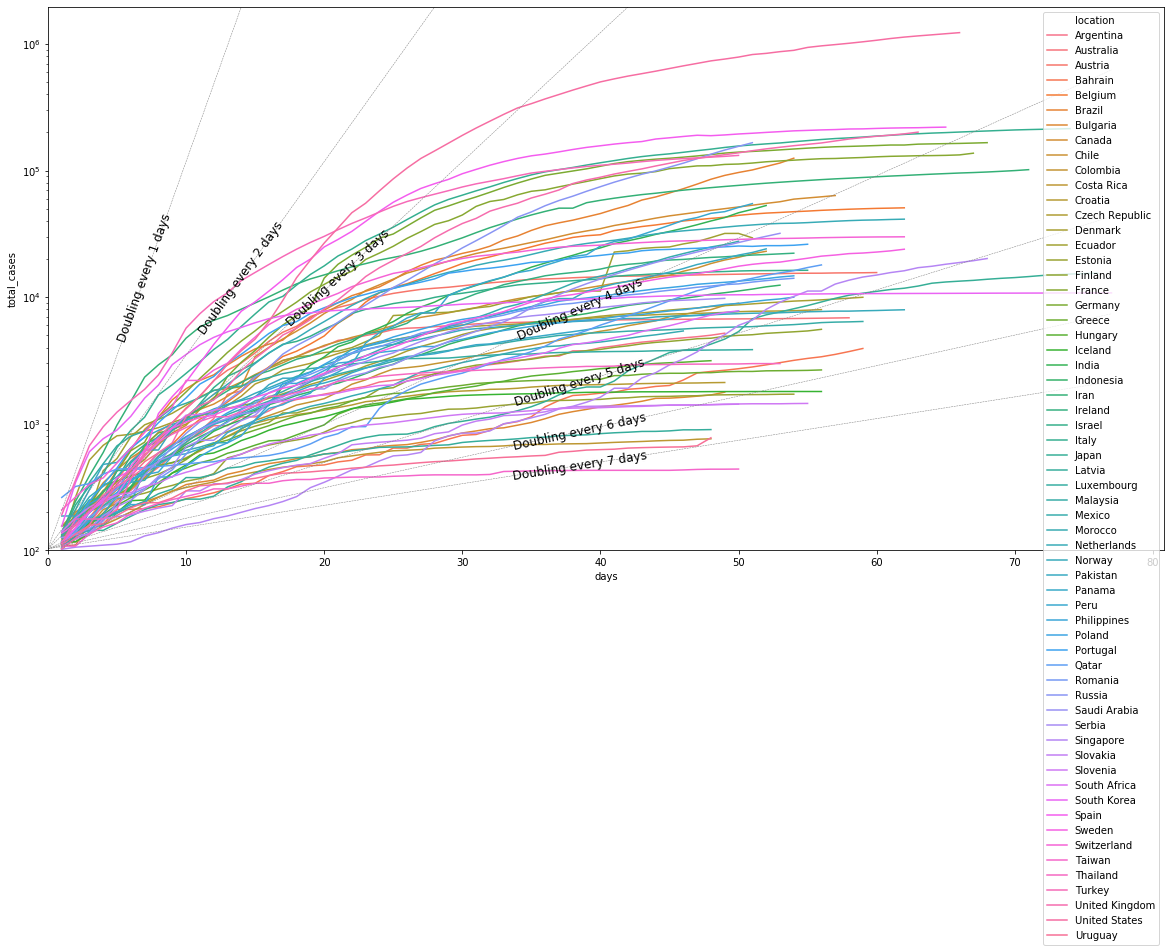

In [11]:
#variable created to initialize maximum value on x-axis and minimum value on y-axis
max_days = ndf["days"].max()
min_cases = ndf["total_cases"].min()

#plot graph as in slide 2 - task 2 on log scale with yaxis staring from 100 and x-axis from 0
fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(x="days", y="total_cases", hue="location",data=ndf)
plt.yscale('log')
plt.ylim(ymin = 100)
plt.xlim(xmin=0.0)

#doubling line with different rate to be inserted in the graph
labelled_refence_lines(1)
labelled_refence_lines(2)
labelled_refence_lines(3)
labelled_refence_lines(4)
labelled_refence_lines(5)
labelled_refence_lines(6)
labelled_refence_lines(7)

#legend at the upper right corner
ax.legend(loc='upper right')

#saving the plot
plt.savefig('/Users/digisha/Downloads/covid_curve.png')

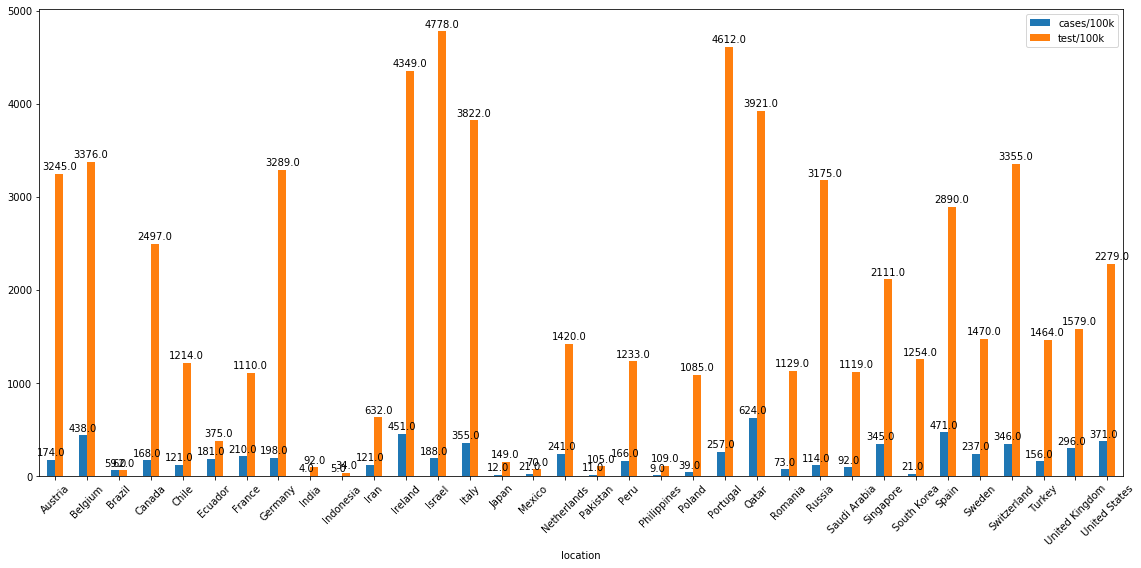

In [20]:
fig, ax = plt.subplots(figsize=(16, 8))

#plot only countries with more that 1000 cases and with atleast a week of data after the 100th case
data_barchart = result[(result['cases'] > 10000) & (result['100th_case'] > 6)].reset_index(drop=True)

#drop rows with NaN values
data_barchart.dropna(inplace=True)

data_barchart.plot.bar(x = 'location', y = ['cases/100k', 'test/100k'], rot = 45, ax = ax)
for p in ax.patches: 
    ax.annotate(p.get_height(), (p.get_x()+p.get_width()/2, p.get_height()+25), ha='center', va='bottom')

plt.tight_layout()
plt.savefig('/Users/digisha/Downloads/barplot_test_cases_comaparision.png')

In [13]:
#using r geo plot was produces, but the data is processed here

#list of percentage change between last week to the current week
list_percentage_change = []
country_list = []

for location in countries:
    #summation variables initialized, to have sum of new cases in current and previous week
    new_cases_week_N = 0
    new_cases_prev_week = 0
    
    #temporary dataframe created with only location country data, sorted my descending date
    temp_df = ndf[ndf['location']==location].sort_values(by=['date'],ascending = [False]).reset_index(drop=True)
    
    if len(temp_df)>13:
        for i in range(14):
            # sum of new cases, for i < 7 for current week data and sum of new cases 6 < i < 14 for previous week data
            if i < 7:
                #print(temp_df['new_cases'][i])
                new_cases_week_N = new_cases_week_N + temp_df['new_cases'][i]
            else:
                new_cases_prev_week += temp_df['new_cases'][i]

    # Calculating percentage change and appending it in the list
        percentage_change = ((new_cases_week_N - new_cases_prev_week)*100)/new_cases_prev_week
        list_percentage_change.append(percentage_change)
        country_list.append(location)

#creating geo dataframe with location and precentage change 
geo_df = pd.DataFrame({'location': country_list, 'percentage_change': list_percentage_change})
geo_df.to_csv(r'/Users/digisha/Downloads/geo.csv', index = False, header=True)
geo_df

,location,percentage_change
0,Argentina,-7.329317
1,Australia,40.217391
2,Austria,-34.772727
3,Bahrain,10.831510
4,Belgium,-51.055276
5,Brazil,45.212159
6,Bulgaria,-21.749409
7,Canada,4.391655
8,Chile,127.444971
9,Colombia,48.140162
